# R C3X fidelity check

24 Dec 2019

origined by rum

---
In this code, two types of R-Toffoli gate are checked fidelity on real device

In [1]:
## import tools
## Import numpy 
import numpy as np
from numpy import pi

## import plot tools
import matplotlib.pyplot as plt
import matplotlib.cm as cm
## To plot heatmap
import seaborn as sns

## import datetime
from datetime import datetime

## Import qiskit tools
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute, Aer, IBMQ
from qiskit.tools.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor

## import qiskit backend monitor
from  qiskit.tools.monitor import backend_monitor

## import qiskit readout error mitigation tools
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, CompleteMeasFitter)

ModuleNotFoundError: No module named 'numpy.core._multiarray_umath'

---
# 1. Get device

In [2]:
IBMQ.load_account()

/Users/Yasuhiro/anaconda3/lib/python3.7/site-packages/qiskit/providers/models/backendconfiguration.py:337: UserWarning: `dt` and `dtm` now have units of seconds(s) rather than nanoseconds(ns).
  warnings.warn('`dt` and `dtm` now have units of seconds(s) rather '


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

### Here to choose provider

In [3]:
## keio-internal device
provider = IBMQ.get_provider(hub='ibm-q-keio', group='keio-internal', project='keio-students')

## reservations
# provider = IBMQ.get_provider(hub='ibm-q-keio', group='keio-internal', project='reservations')

## open device
# provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')

### Define the backend device

In [4]:
device = provider.get_backend("ibmqx2")

---
# 2. Define circuit

### 2-1. Define R-Toffoli as function

---
### R-Toffoli_m
<img src="../img/RToffoli_m.png" />

In [5]:
## define RTof function
def RTof_m(qc, c1, c2, t):
    qc.ry(pi/4, t)
    qc.cx(c2, t)
    qc.ry(pi/4, t)
    qc.cx(c1, t)
    qc.ry(-pi/4, t)
    qc.cx(c2, t)
    qc.ry(-pi/4, t)

---
### R-Toffoli_ix
<img src="../img/RToffoli_ix.png" />

In [6]:
def RTof_ix(qc, c1, c2, t):
#     qc.h(t)
#     qc.t(t)
    qc.u2(pi/4, pi, t)
    qc.cx(c2, t)
    qc.tdg(t)
    qc.cx(c1, t)
    qc.t(t)
    qc.cx(c2, t)
#     qc.tdg(t)
#     qc.h(t)
    qc.u2(0, 3*pi/4, t)

---
### Toffoli gate with one swap
<img src = "../img/Toffoli_SWAP.png" />

In [7]:
## Toffoli gate with one swap
def Toffoli_SWAP(circuit, control1,  control2, target):
    
    """
    c1, c2, t => c1, t, c2
    """
    
    circuit.h(target)
    circuit.cx(control1, target)
    circuit.tdg(target)
    circuit.cx(control2, target)
    circuit.t(target)
    circuit.cx(control1, target)
    circuit.tdg(target)
    circuit.cx(target, control2) ## SWAP
    circuit.cx(control2, target) ## SWAP
    circuit.t(control1)
    circuit.t(control2)
    circuit.cx(target ,control1)
    circuit.tdg(control1)
    circuit.h(control2)
    circuit.t(target)
    circuit.cx(target, control1)

### 2-2. Compose circuit

In [8]:
## define qubit label as num_qubits
num_qubits = len(device.configuration().gates[0].coupling_map)


## Define the list to store the circuit lists of each qubits of the processor
RTof_qc = []

## define init_list
init_list = [format(j, '03b') for j in range(8)]


## define qubit
c1, c2, targ = [0, 1, 2]

In [9]:
## repeat circuit definition for each init_list
for init in init_list:

    ## define circuit
    qr = QuantumRegister(3, "q")
    cr = ClassicalRegister(3, "c")
    circuit = QuantumCircuit(qr, cr)

    ## Initialization
    if(init[0] == '1'):
        circuit.x(qr[c1])
    if(init[1] == '1'):
        circuit.x(qr[c2])
    if(init[2] == '1'):
        circuit.x(qr[int(targ)])

    ## R-Tof_m
    RTof_m(circuit, qr[c1], qr[c2], qr[targ])
    
    ## insert barrier between gates and measurement
    circuit.barrier()

    ## measure the qubit
    circuit.measure(qr[c1], cr[2])
    circuit.measure(qr[c2], cr[1])
    circuit.measure(qr[targ], cr[0])

    ## Append the circuit to the init_list_qc list
    RTof_qc.append(circuit)

In [10]:
## repeat circuit definition for each init_list
for init in init_list:

    ## define circuit
    qr = QuantumRegister(3, "q")
    cr = ClassicalRegister(3, "c")
    circuit = QuantumCircuit(qr, cr)

    ## Initialization
    if(init[0] == '1'):
        circuit.x(qr[c1])
    if(init[1] == '1'):
        circuit.x(qr[c2])
    if(init[2] == '1'):
        circuit.x(qr[int(targ)])

    ## R-Tof_m
    RTof_ix(circuit, qr[c1], qr[c2], qr[targ])
    
    ## insert barrier between gates and measurement
    circuit.barrier()

    ## measure the qubit
    circuit.measure(qr[c1], cr[2])
    circuit.measure(qr[c2], cr[1])
    circuit.measure(qr[targ], cr[0])

    ## Append the circuit to the init_list_qc list
    RTof_qc.append(circuit)

In [11]:
RTof_qc[0].draw()

---
# 3. Run on QASM simulator

### 3-1. Execution

In [12]:
## define simulator
simulator = Aer.get_backend("qasm_simulator")

## define shots
shots = 8192

## define repeat length
in_len = len(init_list)

## define job
job_sim = execute(RTof_qc, backend = simulator, shots = shots)
result_sim = job_sim.result()


## define the list to imidiately store the counts of the each circuit
## repeat # of each angle circuits times
counts_sim_m = [result_sim.get_counts(init) for init in range(in_len)]
counts_sim_ix = [result_sim.get_counts(init) for init in range(in_len, 2*in_len)]

In [13]:
print('counts_sim_m = ', counts_sim_m)

counts_sim_m =  [{'000': 8192}, {'001': 8192}, {'010': 8192}, {'011': 8192}, {'100': 8192}, {'101': 8192}, {'111': 8192}, {'110': 8192}]


In [14]:
print('counts_sim_ix = ', counts_sim_ix)

counts_sim_ix =  [{'000': 8192}, {'001': 8192}, {'010': 8192}, {'011': 8192}, {'100': 8192}, {'101': 8192}, {'111': 8192}, {'110': 8192}]


### 3-2. Plot the result

In [15]:
## define length of repeat
input_len = len(counts_sim_m)
output_bin = [format(num, '03b') for num in range(8)]


sim_m_data = [[(counts_sim_m[inputvalue].get(outputvalue, 0))/shots for outputvalue in output_bin] for inputvalue in range(input_len)]
sim_ix_data = [[(counts_sim_ix[inputvalue].get(outputvalue, 0))/shots for outputvalue in output_bin] for inputvalue in range(input_len)]

In [16]:
print(sim_m_data)

[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]]


########################## R-C3X_m ############################


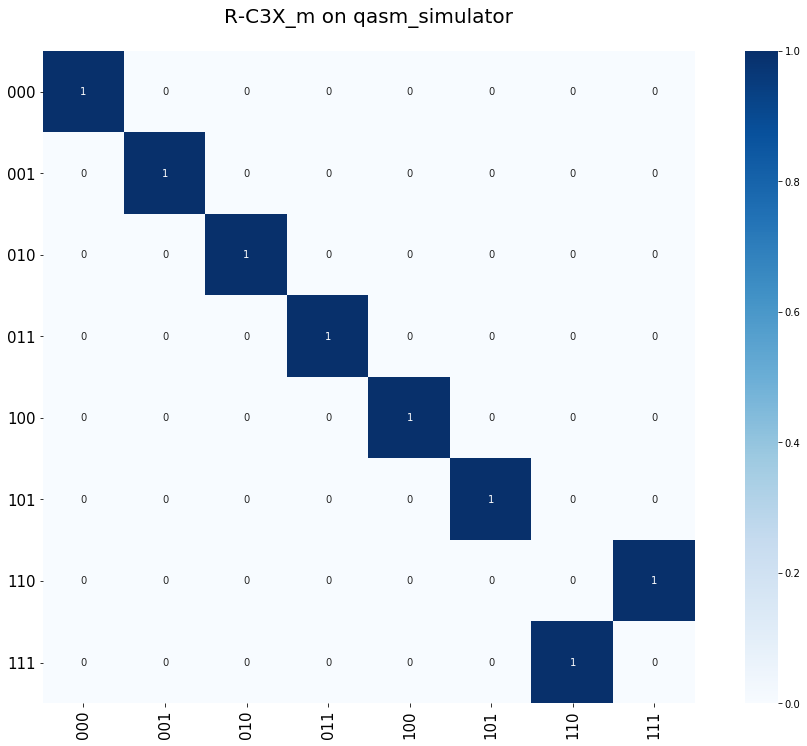

########################## R-C3X_ix ############################


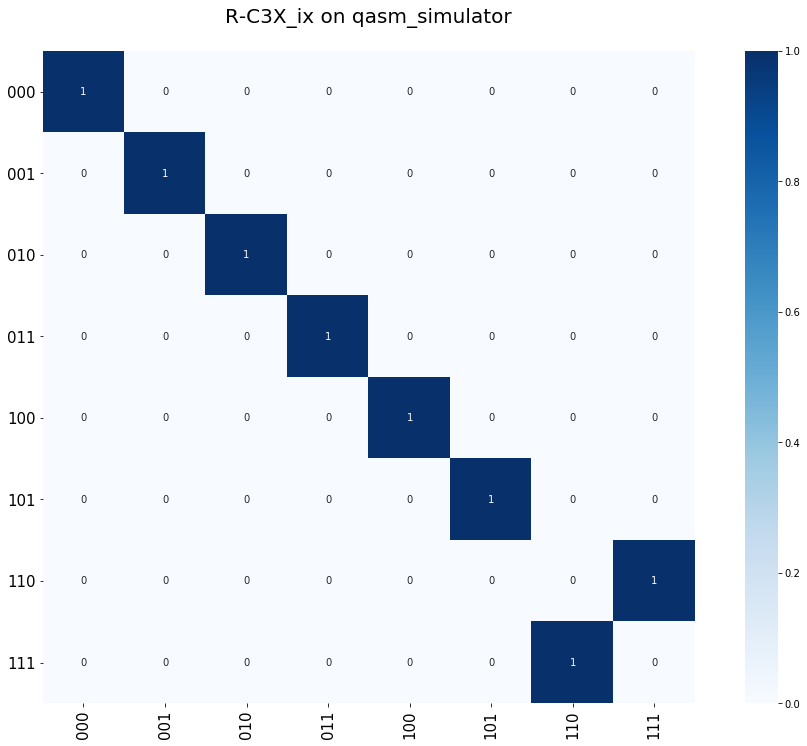

In [17]:
print("########################## R-C3X_m ############################")

## axix range and data labels
### axix range
length=[num+0.5 for num in range(8)]
### labels 
X = [format(num, "03b") for num in range(8)]
Y = X
#######################################################################
## set size
fig,ax = plt.subplots(figsize=(18, 12))
## title
plt.title("R-C3X_m on "+str(simulator)+"\n", 
          fontsize=20
         )

## plot data
sns.heatmap(sim_m_data, 
            vmin = 0.0,  ## define maximum value
            vmax=1.0,   ## defnie minimum value
            annot=True, ## show the numerical data
            square=True,  ## set heatmap to square shape
            cmap=plt.get_cmap('Blues') ## define the color
           )

## axis
plt.xticks(length, 
           X, 
           rotation=90, 
           fontsize=15
          )
plt.yticks(length, 
           Y, 
           rotation=0, 
           fontsize=15)

plt.show()

print("########################## R-C3X_ix ############################")

## axix range and data labels
### axix range
length=[num+0.5 for num in range(8)]
### labels 
X = [format(num, "03b") for num in range(8)]
Y = X
#######################################################################
## set size
fig,ax = plt.subplots(figsize=(18, 12))
## title
plt.title("R-C3X_ix on "+str(simulator)+"\n", 
          fontsize=20
         )

## plot data
sns.heatmap(sim_ix_data, 
            vmin = 0.0,  ## define maximum value
            vmax=1.0,   ## defnie minimum value
            annot=True, ## show the numerical data
            square=True,  ## set heatmap to square shape
            cmap=plt.get_cmap('Blues') ## define the color
           )

## axis
plt.xticks(length, 
           X, 
           rotation=90, 
           fontsize=15
          )
plt.yticks(length, 
           Y, 
           rotation=0, 
           fontsize=15)

plt.show()

---
# 4. Run on Realdevice

In [18]:
backend_monitor(device)

ibmqx2
Configuration
-------------
    n_qubits: 5
    operational: True
    status_msg: active
    pending_jobs: 0
    backend_version: 2.0.1
    basis_gates: ['u1', 'u2', 'u3', 'cx', 'id']
    local: False
    simulator: False
    max_experiments: 75
    backend_name: ibmqx2
    allow_q_circuit: False
    online_date: 2017-01-24T05:00:00+00:00
    sample_name: sparrow
    quantum_volume: 8
    description: 5 qubit device
    credits_required: True
    allow_object_storage: True
    open_pulse: False
    max_shots: 8192
    allow_q_object: True
    conditional: False
    n_registers: 1
    coupling_map: [[0, 1], [0, 2], [1, 0], [1, 2], [2, 0], [2, 1], [2, 3], [2, 4], [3, 2], [3, 4], [4, 2], [4, 3]]
    memory: True
    url: None

Qubits [Name / Freq / T1 / T2 / U1 err / U2 err / U3 err / Readout err]
-----------------------------------------------------------------------
    Q0 / 5.28628 GHz / 62.96847 µs / 48.68627 µs / 0.0 / 0.00044 / 0.00088 / 0.008
    Q1 / 5.2379 GHz / 62.98642 µ

### 4-1. finding the qubit mapping list

In [19]:
## Get qubit coupling map
conf = device.configuration()
coupling_map = conf.coupling_map
print(coupling_map)

[[0, 1], [0, 2], [1, 0], [1, 2], [2, 0], [2, 1], [2, 3], [2, 4], [3, 2], [3, 4], [4, 2], [4, 3]]


In [20]:
## searching the qubit mapping list from coupling_map
#
#
import numpy as np
from collections import Counter
from copy import copy

## get qubit coupling_map from configuraion
conf=device.configuration()
coupling_map = conf.coupling_map


hub_list = []
adj_qubit_list=[]
qubit_mapping=[]

## finding hubs of mapping
counter = Counter(np.ravel(coupling_map))
for qubit, cnt in counter.most_common():
#     print(qubit, ":", cnt)
    if(cnt>=4):
        hub_list.append([qubit]) 

## finding the adjacency qubits of hub-qubit
for hub in hub_list:
    adj_list=[]
    for con in range(len(coupling_map)):
        if(coupling_map[con][0]==hub[0]):
            adj = coupling_map[con][1]
            
            ## append adjacency qubit
            adj_list.append(adj)
    adj_qubit_list.append([hub[0], adj_list])
# print(adj_qubit_list)

## sorting the arrangement
for hub in adj_qubit_list:
    for c1 in range(len(hub[1])):
        for c2 in range(len(hub[1])):
            if hub[1][c2] != hub[1][c1]:
                mapping = []
                mapping.append(hub[1][c1])
                mapping.append(hub[1][c2])
                mapping.append(hub[0])
#                 print(mapping)
                
                qubit_mapping.append(mapping)
        
print("qubit_mapping = ", qubit_mapping)

qubit_mapping =  [[0, 1, 2], [0, 3, 2], [0, 4, 2], [1, 0, 2], [1, 3, 2], [1, 4, 2], [3, 0, 2], [3, 1, 2], [3, 4, 2], [4, 0, 2], [4, 1, 2], [4, 3, 2], [1, 2, 0], [2, 1, 0], [0, 2, 1], [2, 0, 1], [2, 4, 3], [4, 2, 3], [2, 3, 4], [3, 2, 4]]


### 4-2. Define mitigation circuit

In [21]:
qr = QuantumRegister(3)
meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal')

In [22]:
print(meas_calibs)
print(state_labels)

[<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x1a1e414da0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x1a1e414be0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x1a1e414a58>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x1a1e414f28>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x1a1dd30748>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x1a1e41a0b8>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x1a1e41a358>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x1a1e41a588>]
['000', '001', '010', '011', '100', '101', '110', '111']


### 4-3. Execution

In [23]:
# ## define shots
# shots = 8192

# ## define the lists to store job_id
# job_id_list = []
# cal_job_id_list = []

# ## repeat # of qubit_mapping times
# for mapping in qubit_mapping:
    
#     ## job for circuit execution
#     job_exp = execute(RTof_qc,
#                       backend = device, 
#                       shots = shots,
#                       initial_layout=mapping,
#                       optimization_level = 0
#                      )
#     job_id_list.append(job_exp.job_id())
#     print('sent the job', mapping)

    
#     ## job for meas_cal
#     cal_job = execute(meas_calibs, 
#                     backend = device,
#                     shots=shots,
#                     initial_layout=mapping,
#                     optimization_level=0
#                     )
#     cal_job_id_list.append(cal_job.job_id())
#     print('sent the cal_job', mapping)
    
# #     ## get results
# #     result_exp = job_exp.result()
# #     result_cal = cal_job.result()
    
# #     result_exp_list.append(result_exp)
# #     result_cal_exp_list.append(result_cal)

# print('job_id_list = ', job_id_list)
# print('cal_job_id_list = ', cal_job_id_list)

In [24]:
job_id_list =  ['5e01ce26619aa80011ca5f1e', '5e01ce2e58c50e0012c3386d', '5e01ce3203bd6f001205ba05', '5e01ce3776be6000126d8cb0', '5e01ce3b27f7840012679bcb', '5e01ce4176be6000126d8cb1', '5e01ce452b1101001312bfd6', '5e01ce4a27f7840012679bcd', '5e01ce4ea4bcd300114dafef', '5e01ce5276be6000126d8cb4', '5e01ce5658c50e0012c33871', '5e01ce5a27f7840012679bcf', '5e01ce5ea4bcd300114daff1', '5e01ce6276be6000126d8cb7', '5e01ce66c3b5500011d53167', '5e01ce6bc3b5500011d53168', '5e01ce6f27f7840012679bd3', '5e01ce7327f7840012679bd4', '5e01ce7803bd6f001205ba0b', '5e01ce7ba4bcd300114daff4']
cal_job_id_list =  ['5e01ce2931ea3200124695dd', '5e01ce302b1101001312bfd1', '5e01ce3403bd6f001205ba06', '5e01ce39c3b5500011d53162', '5e01ce3ea4bcd300114dafed', '5e01ce43619aa80011ca5f1f', '5e01ce4758c50e0012c3386f', '5e01ce4c2b1101001312bfd8', '5e01ce50c701fb001187c563', '5e01ce5431ea3200124695df', '5e01ce5876be6000126d8cb6', '5e01ce5c03bd6f001205ba08', '5e01ce602b1101001312bfd9', '5e01ce6527f7840012679bd2', '5e01ce6976be6000126d8cb8', '5e01ce6ca4bcd300114daff3', '5e01ce7131ea3200124695e2', '5e01ce7576be6000126d8cba', '5e01ce7ac701fb001187c567', '5e01ce7dc701fb001187c568']

### 4-4. retrieve the job and get the result

In [25]:
        ## Define the list to store the result_exp for error mitigation
result_exp_list = []
result_cal_exp_list = []

for job_id, cal_job_id in zip(job_id_list, cal_job_id_list) :
    ## retrieve jobs
    retrieved_job = device.retrieve_job(job_id)
    retrieved_cal_job = device.retrieve_job(cal_job_id)
    print("jobs were retrieved")
    result_exp = retrieved_job.result()
    print("got exp result")
    result_cal_exp = retrieved_cal_job.result()
    print("got cal_exp result")
    ## Append results_exp to the result_exp_list for error mitigation operation
    result_exp_list.append(result_exp)
    result_cal_exp_list.append(result_cal_exp)

print(result_exp_list)
print(result_cal_exp_list)

jobs were retrieved
got exp result
got cal_exp result
jobs were retrieved
got exp result
got cal_exp result
jobs were retrieved
got exp result
got cal_exp result
jobs were retrieved
got exp result
got cal_exp result
jobs were retrieved
got exp result
got cal_exp result
jobs were retrieved
got exp result
got cal_exp result
jobs were retrieved
got exp result
got cal_exp result
jobs were retrieved
got exp result
got cal_exp result
jobs were retrieved
got exp result
got cal_exp result
jobs were retrieved
got exp result
got cal_exp result
jobs were retrieved
got exp result
got cal_exp result
jobs were retrieved
got exp result
got cal_exp result
jobs were retrieved
got exp result
got cal_exp result
jobs were retrieved
got exp result
got cal_exp result
jobs were retrieved
got exp result
got cal_exp result
jobs were retrieved
got exp result
got cal_exp result
jobs were retrieved
got exp result
got cal_exp result
jobs were retrieved
got exp result
got cal_exp result
jobs were retrieved
got exp 

# Readout Error mitigation

The calibration matrix 

[[9.85107422e-01 2.40478516e-02 3.35693359e-02 1.22070312e-03
  1.98974609e-02 9.76562500e-04 1.22070312e-03 0.00000000e+00]
 [6.83593750e-03 9.66796875e-01 1.50146484e-02 2.72216797e-02
  2.44140625e-04 2.05078125e-02 2.56347656e-03 4.88281250e-04]
 [3.54003906e-03 1.22070312e-04 8.18725586e-01 1.85546875e-02
  7.32421875e-04 0.00000000e+00 2.05078125e-02 2.44140625e-04]
 [3.66210938e-04 3.78417969e-03 1.29638672e-01 9.48364258e-01
  0.00000000e+00 3.66210938e-04 3.17382812e-03 2.17285156e-02]
 [3.41796875e-03 2.44140625e-04 3.66210938e-04 0.00000000e+00
  7.27416992e-01 1.44042969e-02 3.12500000e-02 8.54492188e-04]
 [1.22070312e-04 4.27246094e-03 0.00000000e+00 3.66210938e-04
  5.37109375e-03 8.13354492e-01 1.87988281e-02 2.38037109e-02]
 [6.10351562e-04 0.00000000e+00 2.44140625e-03 0.00000000e+00
  2.44506836e-01 5.73730469e-03 7.90039062e-01 1.73339844e-02]
 [0.00000000e+00 7.32421875e-04 2.44140625e-04 4.27246094e-03
  1.83105469e-03 1.44653320e-01 1.3244

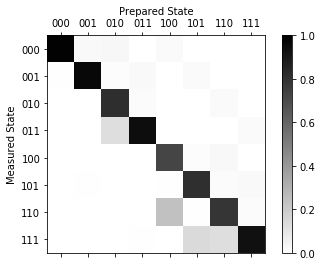

Average Measurement Fidelity: 0.873169 

The calibration matrix 

[[9.22607422e-01 2.03857422e-02 7.92236328e-02 2.07519531e-03
  2.27050781e-02 3.66210938e-04 2.44140625e-03 0.00000000e+00]
 [8.42285156e-03 9.12841797e-01 7.32421875e-04 7.75146484e-02
  2.44140625e-04 2.14843750e-02 0.00000000e+00 2.80761719e-03]
 [6.05468750e-02 1.34277344e-03 9.05761719e-01 1.90429688e-02
  3.90625000e-03 1.22070312e-04 2.51464844e-02 7.32421875e-04]
 [7.32421875e-04 5.79833984e-02 6.34765625e-03 8.96118164e-01
  0.00000000e+00 4.39453125e-03 7.32421875e-04 2.56347656e-02]
 [4.39453125e-03 3.66210938e-04 9.76562500e-04 0.00000000e+00
  9.10644531e-01 1.79443359e-02 7.03125000e-02 1.58691406e-03]
 [1.22070312e-04 4.88281250e-03 1.22070312e-04 3.66210938e-04
  9.52148438e-03 8.93310547e-01 1.46484375e-03 7.12890625e-02]
 [3.17382812e-03 1.22070312e-04 6.71386719e-03 1.22070312e-04
  5.22460938e-02 2.19726562e-03 8.91601562e-01 1.62353516e-02]
 [0.00000000e+00 2.07519531e-03 1.22070312e-04 4.76074219e-

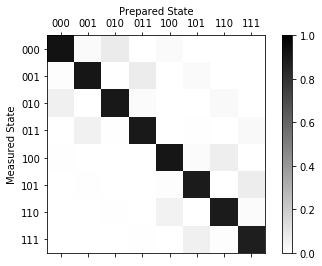

Average Measurement Fidelity: 0.901825 

The calibration matrix 

[[9.73999023e-01 1.97753906e-02 5.20019531e-02 1.22070312e-03
  2.58789062e-02 1.22070312e-03 4.39453125e-03 1.22070312e-04]
 [9.76562500e-03 9.67041016e-01 8.54492188e-04 5.20019531e-02
  0.00000000e+00 2.31933594e-02 0.00000000e+00 4.51660156e-03]
 [6.46972656e-03 2.44140625e-04 9.27368164e-01 2.17285156e-02
  2.68554688e-03 0.00000000e+00 2.29492188e-02 8.54492188e-04]
 [1.22070312e-04 6.10351562e-03 9.64355469e-03 9.15893555e-01
  0.00000000e+00 3.05175781e-03 0.00000000e+00 2.09960938e-02]
 [5.98144531e-03 0.00000000e+00 3.17382812e-03 1.22070312e-04
  9.53369141e-01 1.94091797e-02 5.26123047e-02 8.54492188e-04]
 [0.00000000e+00 4.15039062e-03 0.00000000e+00 4.63867188e-03
  1.11083984e-02 9.47509766e-01 1.22070312e-04 5.01708984e-02]
 [3.54003906e-03 0.00000000e+00 6.83593750e-03 1.22070312e-04
  6.83593750e-03 1.22070312e-04 9.10766602e-01 1.86767578e-02]
 [1.22070312e-04 2.68554688e-03 1.22070312e-04 4.27246094e-

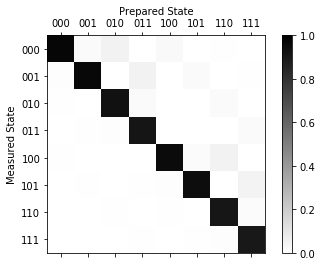

Average Measurement Fidelity: 0.937469 

The calibration matrix 

[[9.85473633e-01 3.63769531e-02 2.18505859e-02 8.54492188e-04
  2.29492188e-02 1.09863281e-03 8.54492188e-04 0.00000000e+00]
 [3.29589844e-03 8.17504883e-01 0.00000000e+00 2.09960938e-02
  4.88281250e-04 2.34375000e-02 0.00000000e+00 6.10351562e-04]
 [7.08007812e-03 1.51367188e-02 9.69116211e-01 2.57568359e-02
  2.44140625e-04 3.17382812e-03 2.61230469e-02 4.88281250e-04]
 [3.66210938e-04 1.26953125e-01 4.88281250e-03 9.47143555e-01
  0.00000000e+00 4.63867188e-03 8.54492188e-04 2.28271484e-02]
 [3.17382812e-03 3.66210938e-04 0.00000000e+00 0.00000000e+00
  7.23266602e-01 3.25927734e-02 1.70898438e-02 1.34277344e-03]
 [6.10351562e-04 3.41796875e-03 0.00000000e+00 0.00000000e+00
  2.46093750e-01 7.83569336e-01 5.85937500e-03 2.07519531e-02]
 [0.00000000e+00 0.00000000e+00 3.78417969e-03 0.00000000e+00
  5.61523438e-03 1.66015625e-02 8.09692383e-01 2.35595703e-02]
 [0.00000000e+00 2.44140625e-04 3.66210938e-04 5.24902344e-

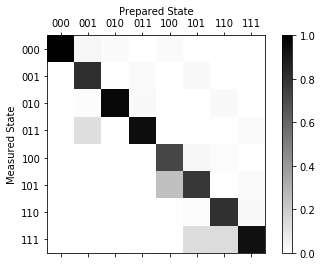

Average Measurement Fidelity: 0.870773 

The calibration matrix 

[[9.30908203e-01 2.16064453e-02 6.77490234e-02 1.58691406e-03
  2.17285156e-02 1.70898438e-03 1.95312500e-03 1.22070312e-04]
 [4.51660156e-03 9.13696289e-01 7.32421875e-04 6.31103516e-02
  1.22070312e-04 2.25830078e-02 0.00000000e+00 1.95312500e-03]
 [5.79833984e-02 1.83105469e-03 9.19067383e-01 2.36816406e-02
  2.92968750e-03 3.66210938e-04 2.14843750e-02 1.34277344e-03]
 [2.44140625e-04 5.66406250e-02 6.22558594e-03 9.02832031e-01
  0.00000000e+00 2.44140625e-03 4.88281250e-04 2.36816406e-02]
 [2.92968750e-03 2.44140625e-04 8.54492188e-04 0.00000000e+00
  6.83227539e-01 2.16064453e-02 4.89501953e-02 1.70898438e-03]
 [1.70898438e-03 4.15039062e-03 3.66210938e-04 1.46484375e-03
  2.31323242e-01 8.95507812e-01 1.57470703e-02 7.06787109e-02]
 [1.22070312e-03 0.00000000e+00 3.90625000e-03 6.10351562e-04
  4.29687500e-02 1.34277344e-03 6.81884766e-01 2.13623047e-02]
 [4.88281250e-04 1.83105469e-03 1.09863281e-03 6.71386719e-

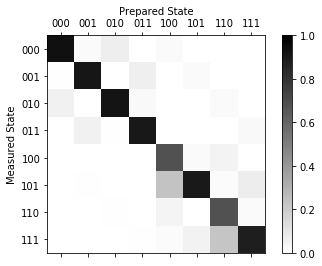

Average Measurement Fidelity: 0.850784 

The calibration matrix 

[[9.79614258e-01 2.67333984e-02 3.61328125e-02 1.34277344e-03
  2.20947266e-02 1.34277344e-03 4.88281250e-03 2.44140625e-04]
 [5.49316406e-03 9.57885742e-01 1.22070312e-04 3.69873047e-02
  0.00000000e+00 2.39257812e-02 0.00000000e+00 4.27246094e-03]
 [5.49316406e-03 0.00000000e+00 9.50073242e-01 2.58789062e-02
  4.88281250e-03 1.22070312e-04 2.30712891e-02 1.58691406e-03]
 [0.00000000e+00 5.12695312e-03 5.00488281e-03 9.28222656e-01
  0.00000000e+00 4.02832031e-03 0.00000000e+00 2.50244141e-02]
 [5.00488281e-03 0.00000000e+00 2.68554688e-03 1.22070312e-04
  7.17651367e-01 2.09960938e-02 2.61230469e-02 6.10351562e-04]
 [1.22070312e-03 6.59179688e-03 8.54492188e-04 2.92968750e-03
  2.49877930e-01 9.43115234e-01 8.05664062e-03 3.18603516e-02]
 [2.19726562e-03 1.22070312e-04 3.41796875e-03 1.22070312e-04
  3.90625000e-03 0.00000000e+00 6.94946289e-01 1.98974609e-02]
 [9.76562500e-04 3.54003906e-03 1.70898438e-03 4.39453125e-

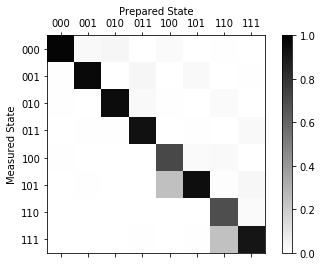

Average Measurement Fidelity: 0.886002 

The calibration matrix 

[[9.21875000e-01 7.33642578e-02 1.89208984e-02 1.22070312e-03
  1.97753906e-02 2.19726562e-03 4.88281250e-04 0.00000000e+00]
 [6.06689453e-02 9.07714844e-01 1.09863281e-03 2.20947266e-02
  3.54003906e-03 2.46582031e-02 1.22070312e-04 4.88281250e-04]
 [1.00097656e-02 1.34277344e-03 9.13940430e-01 6.84814453e-02
  2.44140625e-04 1.22070312e-04 2.19726562e-02 2.07519531e-03]
 [6.10351562e-04 8.17871094e-03 5.95703125e-02 9.01855469e-01
  1.22070312e-04 3.66210938e-04 4.02832031e-03 2.45361328e-02]
 [4.15039062e-03 1.58691406e-03 0.00000000e+00 0.00000000e+00
  9.06372070e-01 7.26318359e-02 2.03857422e-02 2.44140625e-04]
 [2.31933594e-03 7.56835938e-03 0.00000000e+00 2.44140625e-04
  6.12792969e-02 8.88916016e-01 1.22070312e-03 2.01416016e-02]
 [3.66210938e-04 1.22070312e-04 3.54003906e-03 6.10351562e-04
  8.42285156e-03 7.32421875e-04 8.96484375e-01 7.26318359e-02]
 [0.00000000e+00 1.22070312e-04 2.92968750e-03 5.49316406e-

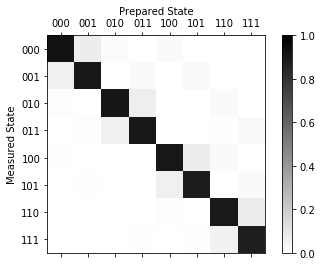

Average Measurement Fidelity: 0.902130 

The calibration matrix 

[[8.93310547e-01 1.03149414e-01 1.90429688e-02 2.31933594e-03
  1.92871094e-02 3.17382812e-03 1.95312500e-03 1.22070312e-04]
 [9.11865234e-02 8.81347656e-01 2.92968750e-03 2.24609375e-02
  4.51660156e-03 2.62451172e-02 0.00000000e+00 1.09863281e-03]
 [7.56835938e-03 1.34277344e-03 8.86962891e-01 1.01928711e-01
  1.22070312e-04 2.44140625e-04 2.58789062e-02 3.41796875e-03]
 [8.54492188e-04 7.08007812e-03 8.25195312e-02 8.65966797e-01
  0.00000000e+00 4.88281250e-04 2.80761719e-03 2.49023438e-02]
 [3.29589844e-03 8.54492188e-04 3.66210938e-04 0.00000000e+00
  6.57226562e-01 7.91015625e-02 2.11181641e-02 2.44140625e-03]
 [1.83105469e-03 3.54003906e-03 3.66210938e-04 4.88281250e-04
  6.89697266e-02 6.47583008e-01 2.07519531e-03 1.81884766e-02]
 [1.22070312e-03 3.66210938e-04 4.76074219e-03 7.32421875e-04
  2.28271484e-01 2.52685547e-02 8.68530273e-01 1.02416992e-01]
 [7.32421875e-04 2.31933594e-03 3.05175781e-03 6.10351562e-

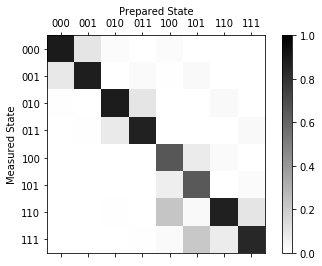

Average Measurement Fidelity: 0.818542 

The calibration matrix 

[[9.02221680e-01 1.23168945e-01 3.06396484e-02 3.17382812e-03
  2.14843750e-02 2.92968750e-03 4.02832031e-03 7.32421875e-04]
 [8.34960938e-02 8.57666016e-01 2.92968750e-03 3.18603516e-02
  4.02832031e-03 2.47802734e-02 7.32421875e-04 4.02832031e-03]
 [3.78417969e-03 8.54492188e-04 8.76342773e-01 1.11938477e-01
  3.05175781e-03 9.76562500e-04 2.24609375e-02 2.92968750e-03]
 [2.44140625e-04 6.34765625e-03 7.83691406e-02 8.40942383e-01
  2.44140625e-04 3.05175781e-03 4.15039062e-03 2.45361328e-02]
 [5.49316406e-03 1.34277344e-03 2.31933594e-03 6.10351562e-04
  8.80371094e-01 1.03637695e-01 2.72216797e-02 3.66210938e-03]
 [2.56347656e-03 7.44628906e-03 4.88281250e-04 3.66210938e-03
  8.48388672e-02 8.57910156e-01 3.54003906e-03 2.66113281e-02]
 [1.83105469e-03 1.22070312e-04 6.46972656e-03 9.76562500e-04
  5.12695312e-03 1.09863281e-03 8.56567383e-01 1.07177734e-01]
 [3.66210938e-04 3.05175781e-03 2.44140625e-03 6.83593750e-

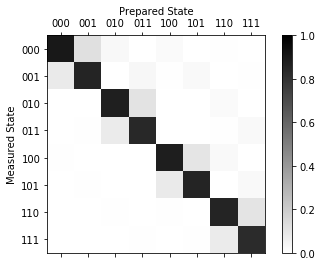

Average Measurement Fidelity: 0.862793 

The calibration matrix 

[[9.73144531e-01 3.67431641e-02 2.35595703e-02 9.76562500e-04
  2.80761719e-02 3.90625000e-03 4.88281250e-04 2.44140625e-04]
 [6.34765625e-03 9.41772461e-01 0.00000000e+00 1.91650391e-02
  3.41796875e-03 2.52685547e-02 0.00000000e+00 8.54492188e-04]
 [1.15966797e-02 0.00000000e+00 9.60571289e-01 2.95410156e-02
  6.10351562e-04 0.00000000e+00 3.03955078e-02 4.27246094e-03]
 [0.00000000e+00 1.01318359e-02 6.34765625e-03 9.41406250e-01
  1.22070312e-04 3.66210938e-04 3.05175781e-03 2.50244141e-02]
 [5.73730469e-03 4.76074219e-03 1.22070312e-04 1.22070312e-04
  9.49951172e-01 3.13720703e-02 2.12402344e-02 3.66210938e-04]
 [2.92968750e-03 6.10351562e-03 2.44140625e-04 0.00000000e+00
  5.85937500e-03 9.30664062e-01 0.00000000e+00 2.01416016e-02]
 [2.44140625e-04 0.00000000e+00 5.49316406e-03 2.44140625e-03
  1.17187500e-02 1.22070312e-04 9.38842773e-01 3.49121094e-02]
 [0.00000000e+00 4.88281250e-04 3.66210938e-03 6.34765625e-

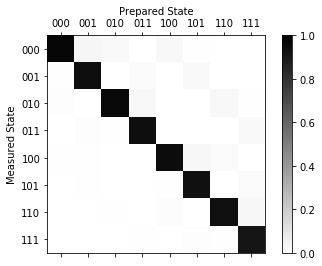

Average Measurement Fidelity: 0.943817 

The calibration matrix 

[[9.81323242e-01 4.26025391e-02 2.62451172e-02 7.32421875e-04
  2.49023438e-02 5.12695312e-03 1.34277344e-03 0.00000000e+00]
 [6.59179688e-03 9.44702148e-01 3.66210938e-04 2.77099609e-02
  2.92968750e-03 2.68554688e-02 2.44140625e-04 2.19726562e-03]
 [3.78417969e-03 2.44140625e-04 9.58740234e-01 4.00390625e-02
  3.66210938e-04 0.00000000e+00 2.51464844e-02 4.51660156e-03]
 [0.00000000e+00 3.78417969e-03 5.12695312e-03 9.22607422e-01
  1.22070312e-04 4.88281250e-04 3.05175781e-03 2.89306641e-02]
 [3.78417969e-03 1.70898438e-03 3.66210938e-04 0.00000000e+00
  7.42431641e-01 3.82080078e-02 2.39257812e-02 1.22070312e-03]
 [1.70898438e-03 4.39453125e-03 3.66210938e-04 3.66210938e-04
  5.12695312e-03 7.09106445e-01 4.88281250e-04 2.02636719e-02]
 [2.19726562e-03 1.22070312e-03 5.85937500e-03 3.90625000e-03
  2.22167969e-01 9.27734375e-03 9.39331055e-01 4.04052734e-02]
 [6.10351562e-04 1.34277344e-03 2.92968750e-03 4.63867188e-

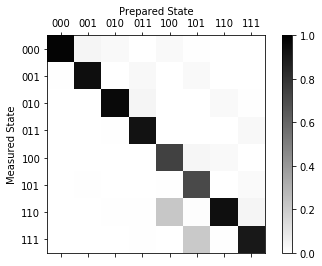

Average Measurement Fidelity: 0.887589 

The calibration matrix 

[[9.24194336e-01 3.12500000e-02 6.94580078e-02 2.80761719e-03
  2.39257812e-02 4.51660156e-03 3.41796875e-03 1.22070312e-04]
 [4.88281250e-03 9.01123047e-01 1.46484375e-03 6.60400391e-02
  2.80761719e-03 2.03857422e-02 2.44140625e-04 2.44140625e-03]
 [5.95703125e-02 1.46484375e-03 9.10034180e-01 3.56445312e-02
  3.66210938e-03 3.66210938e-04 2.49023438e-02 4.15039062e-03]
 [3.66210938e-04 5.40771484e-02 6.95800781e-03 8.82080078e-01
  2.44140625e-04 4.02832031e-03 3.54003906e-03 2.31933594e-02]
 [5.37109375e-03 3.17382812e-03 1.09863281e-03 6.10351562e-04
  9.04541016e-01 2.89306641e-02 7.15332031e-02 2.56347656e-03]
 [3.66210938e-03 5.49316406e-03 2.44140625e-04 7.32421875e-04
  6.46972656e-03 8.85986328e-01 9.76562500e-04 6.68945312e-02]
 [1.70898438e-03 2.44140625e-04 7.20214844e-03 3.66210938e-03
  5.77392578e-02 1.46484375e-03 8.89526367e-01 3.39355469e-02]
 [2.44140625e-04 3.17382812e-03 3.54003906e-03 8.42285156e-

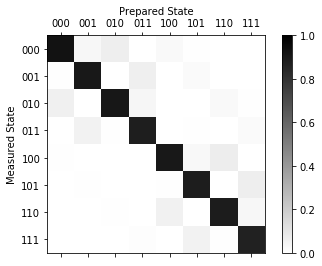

Average Measurement Fidelity: 0.895523 

The calibration matrix 

[[9.86083984e-01 3.56445312e-02 2.11181641e-02 1.34277344e-03
  2.22167969e-02 7.32421875e-04 8.54492188e-04 0.00000000e+00]
 [3.17382812e-03 8.06030273e-01 6.10351562e-04 1.97753906e-02
  0.00000000e+00 1.91650391e-02 0.00000000e+00 1.09863281e-03]
 [2.80761719e-03 3.66210938e-04 7.22167969e-01 3.51562500e-02
  0.00000000e+00 0.00000000e+00 1.53808594e-02 7.32421875e-04]
 [7.32421875e-04 4.51660156e-03 2.47192383e-01 7.93579102e-01
  0.00000000e+00 1.22070312e-04 5.00488281e-03 1.81884766e-02]
 [7.08007812e-03 1.78222656e-02 1.22070312e-04 1.46484375e-03
  9.70458984e-01 2.55126953e-02 2.25830078e-02 7.32421875e-04]
 [1.22070312e-04 1.34887695e-01 0.00000000e+00 3.66210938e-03
  3.41796875e-03 9.48852539e-01 3.66210938e-04 2.27050781e-02]
 [0.00000000e+00 0.00000000e+00 6.83593750e-03 1.55029297e-02
  3.66210938e-03 4.88281250e-04 8.03955078e-01 2.20947266e-02]
 [0.00000000e+00 7.32421875e-04 1.95312500e-03 1.29516602e-

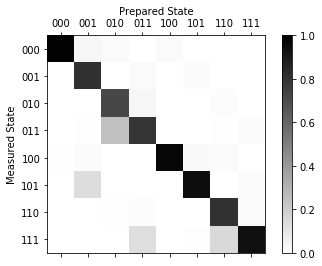

Average Measurement Fidelity: 0.870697 

The calibration matrix 

[[9.84619141e-01 2.28271484e-02 3.78417969e-02 6.10351562e-04
  1.73339844e-02 6.10351562e-04 7.32421875e-04 0.00000000e+00]
 [3.17382812e-03 7.26562500e-01 4.88281250e-04 3.19824219e-02
  0.00000000e+00 1.51367188e-02 0.00000000e+00 4.88281250e-04]
 [2.68554688e-03 2.44140625e-04 8.13110352e-01 1.83105469e-02
  1.22070312e-04 0.00000000e+00 1.94091797e-02 7.32421875e-04]
 [8.54492188e-04 2.41210938e-01 3.54003906e-03 8.01269531e-01
  1.22070312e-04 6.83593750e-03 0.00000000e+00 1.61132812e-02]
 [8.42285156e-03 2.44140625e-04 1.40380859e-02 1.83105469e-03
  9.75585938e-01 2.22167969e-02 2.41699219e-02 9.76562500e-04]
 [0.00000000e+00 7.20214844e-03 3.66210938e-04 1.70898438e-02
  2.92968750e-03 8.10913086e-01 1.22070312e-04 2.11181641e-02]
 [2.44140625e-04 0.00000000e+00 1.30249023e-01 3.54003906e-03
  2.92968750e-03 1.22070312e-04 9.52148438e-01 2.50244141e-02]
 [0.00000000e+00 1.70898438e-03 3.66210938e-04 1.25366211e-

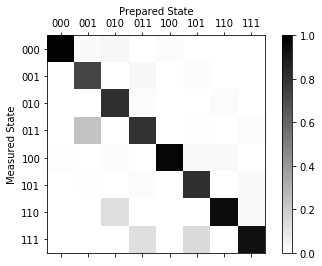

Average Measurement Fidelity: 0.874969 

The calibration matrix 

[[9.84619141e-01 2.11181641e-02 2.16064453e-02 2.44140625e-04
  3.55224609e-02 6.10351562e-04 8.54492188e-04 0.00000000e+00]
 [7.69042969e-03 9.71191406e-01 2.44140625e-04 2.05078125e-02
  1.68457031e-02 2.47802734e-02 1.83105469e-03 6.10351562e-04]
 [2.07519531e-03 2.44140625e-04 7.23144531e-01 1.45263672e-02
  2.44140625e-04 0.00000000e+00 3.54003906e-02 4.88281250e-04]
 [1.22070312e-04 3.54003906e-03 6.83593750e-03 8.04931641e-01
  0.00000000e+00 1.22070312e-04 1.70898438e-02 2.18505859e-02]
 [3.90625000e-03 1.22070312e-04 1.22070312e-04 0.00000000e+00
  8.09082031e-01 1.63574219e-02 1.53808594e-02 4.88281250e-04]
 [7.32421875e-04 3.41796875e-03 0.00000000e+00 1.22070312e-04
  1.35742188e-01 9.55200195e-01 3.54003906e-03 2.01416016e-02]
 [8.54492188e-04 0.00000000e+00 2.46459961e-01 6.95800781e-03
  2.31933594e-03 1.22070312e-04 7.92846680e-01 1.91650391e-02]
 [0.00000000e+00 3.66210938e-04 1.58691406e-03 1.52709961e-

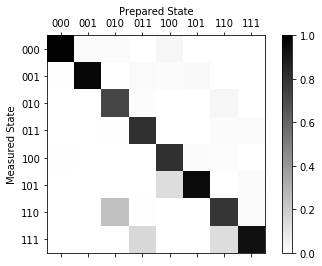

Average Measurement Fidelity: 0.872284 

The calibration matrix 

[[9.84619141e-01 2.46582031e-02 1.87988281e-02 3.66210938e-04
  3.43017578e-02 9.76562500e-04 6.10351562e-04 0.00000000e+00]
 [3.05175781e-03 7.08129883e-01 0.00000000e+00 1.22070312e-02
  3.66210938e-04 3.10058594e-02 0.00000000e+00 7.32421875e-04]
 [7.08007812e-03 3.66210938e-04 9.73388672e-01 2.34375000e-02
  1.89208984e-02 2.56347656e-03 2.61230469e-02 7.32421875e-04]
 [0.00000000e+00 6.83593750e-03 2.80761719e-03 8.03710938e-01
  1.22070312e-04 1.56250000e-02 3.66210938e-04 2.40478516e-02]
 [3.54003906e-03 3.66210938e-04 0.00000000e+00 0.00000000e+00
  8.10302734e-01 1.77001953e-02 1.95312500e-02 3.66210938e-04]
 [8.54492188e-04 2.58422852e-01 0.00000000e+00 5.98144531e-03
  3.17382812e-03 7.87109375e-01 0.00000000e+00 2.16064453e-02]
 [8.54492188e-04 1.22070312e-04 4.02832031e-03 3.66210938e-04
  1.32446289e-01 3.17382812e-03 9.48974609e-01 2.16064453e-02]
 [0.00000000e+00 1.09863281e-03 9.76562500e-04 1.53930664e-

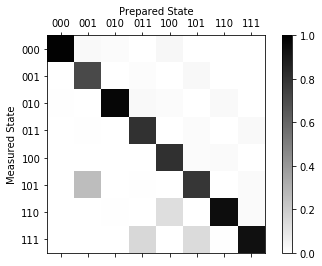

Average Measurement Fidelity: 0.868393 

The calibration matrix 

[[9.22485352e-01 2.28271484e-02 4.16259766e-02 4.02832031e-03
  6.97021484e-02 2.44140625e-03 3.17382812e-03 3.66210938e-04]
 [5.49316406e-03 9.09179688e-01 2.68554688e-03 4.05273438e-02
  1.09863281e-03 6.94580078e-02 3.66210938e-04 3.41796875e-03]
 [6.22558594e-03 2.80761719e-03 8.91967773e-01 1.98974609e-02
  1.83105469e-03 1.22070312e-04 7.22656250e-02 2.44140625e-03]
 [3.41796875e-03 5.00488281e-03 3.41796875e-03 8.71948242e-01
  0.00000000e+00 1.09863281e-03 1.70898438e-03 7.31201172e-02]
 [5.94482422e-02 2.92968750e-03 2.19726562e-03 2.44140625e-04
  9.11010742e-01 2.68554688e-02 4.65087891e-02 4.88281250e-03]
 [2.92968750e-03 5.63964844e-02 0.00000000e+00 2.31933594e-03
  8.66699219e-03 8.90747070e-01 4.51660156e-03 4.27246094e-02]
 [0.00000000e+00 6.10351562e-04 5.60302734e-02 2.92968750e-03
  5.98144531e-03 3.29589844e-03 8.64379883e-01 2.35595703e-02]
 [0.00000000e+00 2.44140625e-04 2.07519531e-03 5.81054688e-

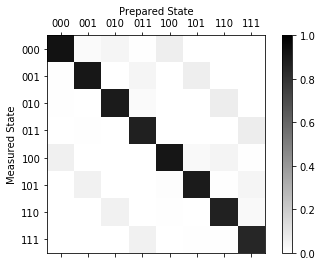

Average Measurement Fidelity: 0.888901 

The calibration matrix 

[[9.25659180e-01 3.35693359e-02 1.98974609e-02 4.39453125e-03
  6.76269531e-02 2.31933594e-03 3.05175781e-03 3.66210938e-04]
 [5.61523438e-03 8.92211914e-01 3.41796875e-03 1.81884766e-02
  9.76562500e-04 6.72607422e-02 3.66210938e-04 2.44140625e-03]
 [5.37109375e-03 3.90625000e-03 9.13452148e-01 3.56445312e-02
  1.70898438e-03 1.22070312e-04 6.95800781e-02 1.83105469e-03]
 [2.68554688e-03 5.61523438e-03 5.49316406e-03 8.75854492e-01
  0.00000000e+00 1.09863281e-03 1.70898438e-03 6.95800781e-02]
 [5.82275391e-02 8.54492188e-04 2.92968750e-03 0.00000000e+00
  9.14794922e-01 3.38134766e-02 2.27050781e-02 4.02832031e-03]
 [2.44140625e-04 6.09130859e-02 1.22070312e-04 3.90625000e-03
  5.37109375e-03 8.86474609e-01 3.78417969e-03 2.24609375e-02]
 [1.95312500e-03 6.10351562e-04 5.43212891e-02 3.05175781e-03
  5.98144531e-03 2.80761719e-03 8.93432617e-01 3.03955078e-02]
 [2.44140625e-04 2.31933594e-03 3.66210938e-04 5.89599609e-

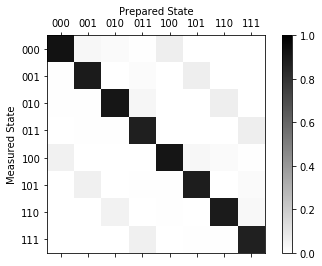

Average Measurement Fidelity: 0.896347 

The calibration matrix 

[[9.27856445e-01 2.56347656e-02 7.32421875e-02 2.68554688e-03
  3.90625000e-02 4.39453125e-03 3.41796875e-03 2.44140625e-04]
 [3.90625000e-03 9.05029297e-01 8.54492188e-04 6.86035156e-02
  3.17382812e-03 4.10156250e-02 1.22070312e-04 3.54003906e-03]
 [5.73730469e-02 2.68554688e-03 9.07836914e-01 2.64892578e-02
  2.44140625e-03 4.88281250e-04 4.12597656e-02 4.02832031e-03]
 [1.70898438e-03 5.68847656e-02 7.08007812e-03 8.91357422e-01
  2.44140625e-04 2.19726562e-03 4.27246094e-03 3.96728516e-02]
 [5.73730469e-03 3.41796875e-03 8.54492188e-04 4.88281250e-04
  8.86962891e-01 2.13623047e-02 6.67724609e-02 1.09863281e-03]
 [3.05175781e-03 5.98144531e-03 2.44140625e-04 8.54492188e-04
  4.63867188e-03 8.70727539e-01 1.09863281e-03 6.49414062e-02]
 [2.44140625e-04 3.66210938e-04 4.88281250e-03 3.78417969e-03
  6.17675781e-02 3.17382812e-03 8.76464844e-01 2.49023438e-02]
 [1.22070312e-04 0.00000000e+00 5.00488281e-03 5.73730469e-

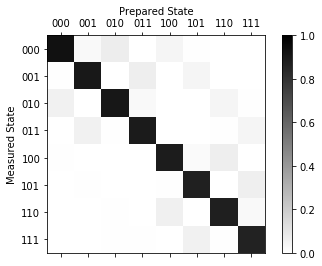

Average Measurement Fidelity: 0.890976 

The calibration matrix 

[[9.32617188e-01 7.15332031e-02 2.18505859e-02 2.68554688e-03
  3.73535156e-02 2.19726562e-03 4.02832031e-03 1.22070312e-04]
 [5.27343750e-02 9.11010742e-01 3.41796875e-03 2.30712891e-02
  2.31933594e-03 3.95507812e-02 4.88281250e-04 4.27246094e-03]
 [5.61523438e-03 7.32421875e-04 9.11376953e-01 6.72607422e-02
  3.66210938e-03 3.66210938e-04 3.58886719e-02 5.12695312e-03]
 [1.46484375e-03 6.10351562e-03 5.60302734e-02 8.96484375e-01
  2.44140625e-04 5.98144531e-03 3.17382812e-03 3.83300781e-02]
 [4.63867188e-03 6.10351562e-04 1.58691406e-03 1.22070312e-04
  8.93798828e-01 7.05566406e-02 2.12402344e-02 2.07519531e-03]
 [4.88281250e-04 6.71386719e-03 1.22070312e-04 4.63867188e-03
  5.41992188e-02 8.73046875e-01 2.68554688e-03 2.16064453e-02]
 [2.31933594e-03 0.00000000e+00 5.37109375e-03 4.88281250e-04
  5.37109375e-03 1.34277344e-03 8.78173828e-01 6.10351562e-02]
 [1.22070312e-04 3.29589844e-03 2.44140625e-04 5.24902344e-

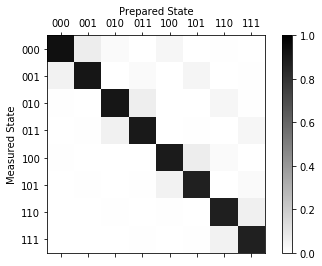

Average Measurement Fidelity: 0.895493 



In [26]:
meas_fitter_list = []

for result_cal_exp in result_cal_exp_list:
    
    ## define measurement fitter
    meas_fitter = CompleteMeasFitter(result_cal_exp, state_labels)
    meas_fitter_list.append(meas_fitter)
    
    print("The calibration matrix \n")
    print(meas_fitter.cal_matrix)

    ## Plot the calibration matrix
    print("Plot the calibration matrix (2D color grid plot)\n")
    meas_fitter.plot_calibration()

    ## The measurement fidelity
    print("Average Measurement Fidelity: %f" % meas_fitter.readout_fidelity(), "\n")

### Apply device calibration parameter to mitigate the result_exp

In [27]:
## define the list to store 
mitigated_m_list = []
mitigated_ix_list = []

## define repeat length
in_len = len(init_list)

## repeat (num_qubits) times
for result_exp, meas_fitter in zip(result_exp_list, meas_fitter_list):
    
    # Get the filter object
    meas_filter = meas_fitter.filter
    
    ## get measurement error mitigated result
    mitigated_results = meas_filter.apply(result_exp)
    mitigated_m_counts = [mitigated_results.get_counts(init) for init in range(in_len)]
    mitigated_ix_counts = [mitigated_results.get_counts(init) for init in range(in_len, 2*in_len)]
    
    ## Append mitigated_counts to mitigated_list
    mitigated_m_list.append(mitigated_m_counts)
    mitigated_ix_list.append(mitigated_ix_counts)

### Show the mitigated counts

In [30]:
print("mitigated_m_counts = ", mitigated_m_list, "\n")
print("mitigated_is_counts = ", mitigated_ix_list, "\n")

mitigated_m_counts =  [[{'100': 158.3460856472101, '000': 7775.38904704321, '001': 52.80151312216453, '011': 54.85276289406746, '010': 144.35660444494576, '110': 1.420417657192058e-11, '111': 6.253986848387748}, {'101': 100.6850925279142, '100': 11.612923625889216, '000': 165.88232099312424, '001': 5802.208292377179, '011': 2097.6382565370286, '010': 3.011133551701628e-13, '111': 13.973113938866229}, {'101': 8.297924095250658e-09, '000': 8.961716437645402, '001': 1.2064032944666697e-09, '100': 1.3293810798753328e-07, '010': 7293.261581837436, '011': 3.7313511350597464e-08, '110': 889.7767022223943, '111': 2.108179989209912e-11}, {'101': 113.72929758073735, '000': 68.26970367576192, '001': 201.436759247622, '100': 21.171648287554163, '010': 155.6523495812133, '011': 6551.035429629272, '110': 121.67155606860987, '111': 959.0332559292304}, {'101': 5.079888598204262e-08, '100': 8191.999999287702, '000': 3.8768505762822094e-10, '001': 2.0353343223472438e-07, '011': 2.103957274183954e-07, '0

In [32]:
print(len(job_id_list))
print(len(mitigated_m_list))

print(len(mitigated_m_counts))

20
20
8


### post data processing

In [33]:
## define length of repeat
input_len = len(mitigated_m_counts)
output_bin = [format(num, '03b') for num in range(8)]


mit_m_data = [[[(mitigated_m_list[mapping][inputvalue].get(outputvalue, 0))/shots for outputvalue in output_bin] for inputvalue in range(input_len)] for mapping in range(len(job_id_list))]
mit_ix_data = [[[(mitigated_ix_list[mapping][inputvalue].get(outputvalue, 0))/shots for outputvalue in output_bin] for inputvalue in range(input_len)] for mapping in range(len(job_id_list))]

In [34]:
print("mit_m_data = ",mit_m_data, "\n")
print("mit_ix_data = ",mit_ix_data, "\n")

mit_m_data =  [[[0.9491441707816418, 0.006445497207295475, 0.017621655816033418, 0.006695893907967219, 0.0193293561581067, 0.0, 1.7339082729395238e-15, 0.0007634261289535825], [0.020249306761855986, 0.7082773794405736, 3.6757001363545264e-17, 0.25605935748743025, 0.0014175932160509297, 0.0122906607089739, 0.0, 0.0017057023851155065], [0.001093959526079761, 1.472660271565759e-13, 0.8902907204391401, 4.5548719910397295e-12, 1.6227796385196934e-11, 1.0129301874085276e-12, 0.10861532009550712, 2.573461900891006e-15], [0.008333704061982656, 0.024589448150344483, 0.01900053095473795, 0.799686942093417, 0.0025844297226018265, 0.013882970896086103, 0.014852484871656479, 0.11706948924917364], [4.732483613625744e-14, 2.4845389677090378e-11, 2.4387459477285423e-11, 2.5683072194628346e-11, 0.9999999999130496, 6.201035886479812e-12, 0.0, 1.3085635746931344e-11], [0.0007649512343826125, 0.009469982099104839, 0.0, 0.011147337202964222, 0.024779733331924094, 0.9538379961316242, 0.0, 0.0], [0.0, 0.0004

In [35]:
def two_matrices_mean(matrix1, matrix2):
    mean = [[(col_0+col_1)/2 for col_0, col_1 in zip(row_0, row_1)] for row_0, row_1 in zip(matrix1, matrix2)]
    return mean

def matrices_mean(array):
    mat = array[0]
    len_mat = len(array)
    for i in range(1, len_mat):
        res = two_matrices_mean(mat, array[i])
        mat = res
    return mat

In [37]:
mit_m_mean = matrices_mean(mit_m_data)
mit_ix_mean = matrices_mean(mit_ix_data)

In [38]:
print("mit_m_mean = ",mit_m_mean)
print("mit_ix_mean = ", mit_ix_mean)

mit_m_mean =  [[0.9141501542838145, 0.03787494492666665, 0.008425686070932963, 0.0021736349586717304, 0.03515629549273745, 0.001678519020868311, 0.0003332493610192178, 0.00020751588669817636], [0.04502260324528068, 0.905506326286309, 0.004149336509971871, 0.009268075608799142, 0.0017301818838257182, 0.033317640841827735, 0.0007690466472432641, 0.000236789055327248], [0.020176850388659223, 0.008851927210011384, 0.8975000915144249, 0.03662959428492383, 0.0014248266672884165, 0.0006812365827956921, 0.028369362169068317, 0.0063661111886178364], [0.010634011165072357, 0.014419824217651119, 0.04539667044506897, 0.8932023076859692, 0.00019650480078542277, 9.772506799885899e-05, 0.005964522975090007, 0.03008843364400478], [0.024073036686768183, 0.0026501571894265905, 0.0003337581601429711, 0.00013054662618169275, 0.9221450367289012, 0.03795803085954892, 0.004590295576264423, 0.008119138176322134], [0.0033340658940855207, 0.028240819105965285, 4.370014809252059e-06, 6.733337688418178e-05, 0.055

### Plot the output matrix

########################## R-Toffoli_m ############################


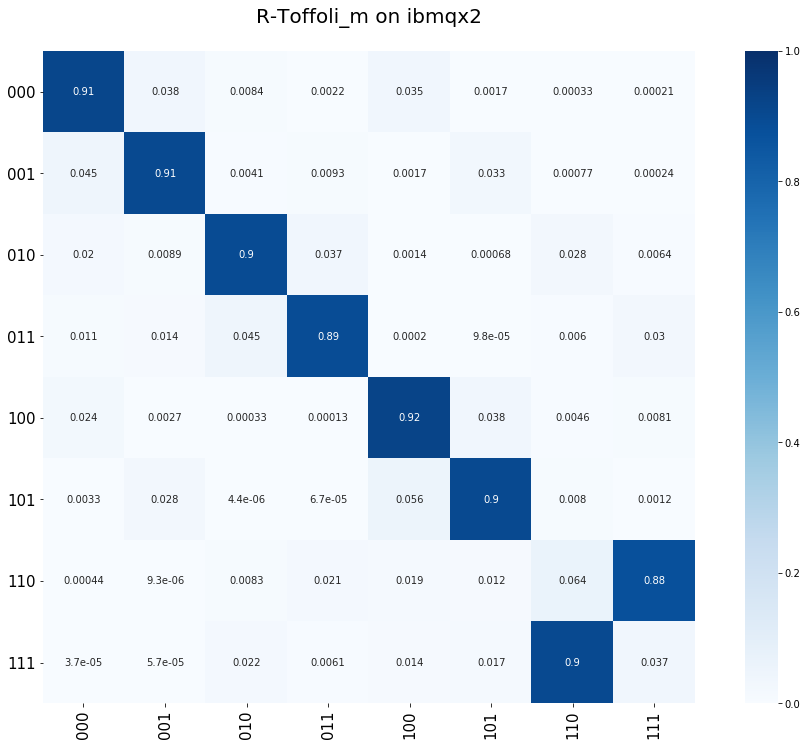

########################## R-Toffoli_ix ############################


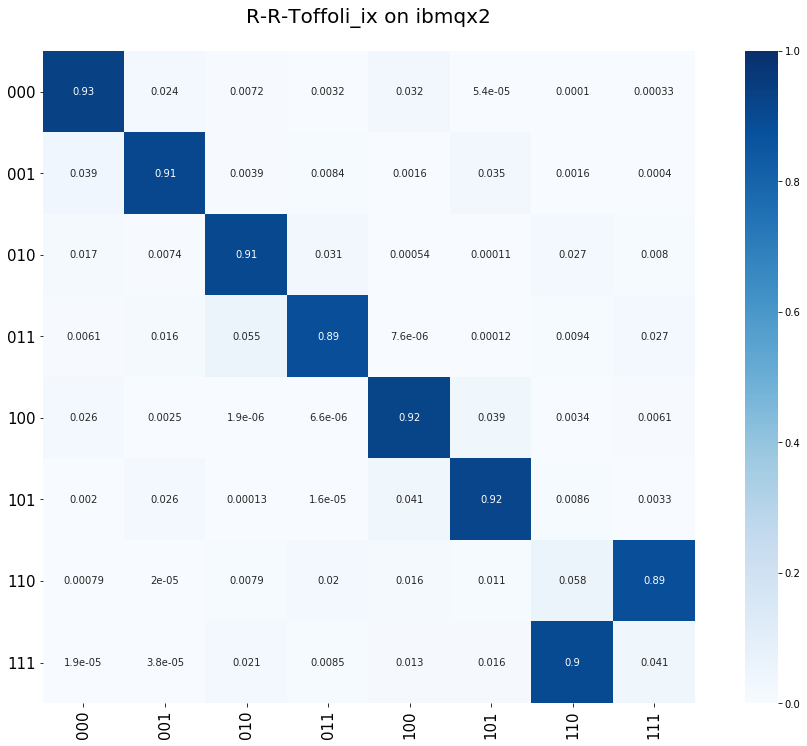

In [39]:
print("########################## R-Toffoli_m ############################")

## axix range and data labels
### axix range
length=[num+0.5 for num in range(8)]
### labels 
X = [format(num, "03b") for num in range(8)]
Y = X
#######################################################################
## set size
fig,ax = plt.subplots(figsize=(18, 12))
## title
plt.title("R-Toffoli_m on "+str(device)+"\n", 
          fontsize=20
         )

## plot data
sns.heatmap(mit_m_mean, 
            vmin = 0.0,  ## define maximum value
            vmax=1.0,   ## defnie minimum value
            annot=True, ## show the numerical data
            square=True,  ## set heatmap to square shape
            cmap=plt.get_cmap('Blues') ## define the color
           )

## axis
plt.xticks(length, 
           X, 
           rotation=90, 
           fontsize=15
          )
plt.yticks(length, 
           Y, 
           rotation=0, 
           fontsize=15)

plt.show()

print("########################## R-Toffoli_ix ############################")

## axix range and data labels
### axix range
length=[num+0.5 for num in range(8)]
### labels 
X = [format(num, "03b") for num in range(8)]
Y = X
#######################################################################
## set size
fig,ax = plt.subplots(figsize=(18, 12))
## title
plt.title("R-R-Toffoli_ix on "+str(device)+"\n", 
          fontsize=20
         )

## plot data
sns.heatmap(mit_ix_mean, 
            vmin = 0.0,  ## define maximum value
            vmax=1.0,   ## defnie minimum value
            annot=True, ## show the numerical data
            square=True,  ## set heatmap to square shape
            cmap=plt.get_cmap('Blues') ## define the color
           )

## axis
plt.xticks(length, 
           X, 
           rotation=90, 
           fontsize=15
          )
plt.yticks(length, 
           Y, 
           rotation=0, 
           fontsize=15)

plt.show()